In [1]:
import sys, os, glob
sys.path.append(os.getenv('src_dir'))

In [2]:
from src.ais_python.ais_processing import *
from src.ais_python.ais_processing.Ais_preprocessing import Ais_processing
from src.ais_python.ais_processing._ais_helper_funcs import *
df = load_dataset(glob.glob(f'{os.getenv("testdata_dir")}/*')[1])


### the module can process AIS in two ways:

1) take a DF with mmsi	time	lat	long	sog	cog and return a DF with alot of info.
    can be used in, e.g., DL 

2) take DF with mmsi	time	lat	long	sog	cog and work with it on a functional level

In [3]:
import datetime

df = load_dataset('../data/test_data/test_data.pkl')
del df['id']
#filtering
df = remove_nan(df)
df = round_data(df,round_coord=6,round_sog=1,round_cog=0)
df = filter_lat(df,lat_min=-180,lat_max=180)
df = filter_long(df,long_min=-180,long_max=180)
df = filter_sog(df,sog_min=0,sog_max=80)
df = filter_cog(df,cog_min=0,cog_max=360)
#
print(df.columns)
print(df.mmsi.min())
df = add_ids_all(df,allowed_stop=600,min_messages=1)
print(df.mmsi.min())
df = interpolate_df(df)
df_closest = get_nearest_time_df(df)
#print(df.columns)}
#df = get_total_distance_single(df)
#print(df.columns)
#df = get_timeleft_single(df)
#df = get_total_time_spent_single(df)
#df = get_dist_pct_single(df)
#df = get_speed_single(df)
#df = get_bearing_single(df)
#del df['total_distance']
#print(df.columns)

Index(['mmsi', 'time', 'lat', 'long', 'sog', 'cog'], dtype='object')
-32672
-32672


In [67]:
type(df)

pandas.core.frame.DataFrame

In [68]:
def get_nearest_time(df: pd.core.frame.DataFrame, s1_time: datetime.datetime):
    df.index = df.time
    return df.iloc[df.index.get_indexer([s1_time], method="nearest")].reset_index(
        drop=True
    )


def get_nearest_time_df(
    df: pd.core.frame.DataFrame,
    s1_time: datetime.datetime = datetime.datetime(2019, 3, 30, 10, 5, 8),
    by: str = "ids",
):
    df = (
        df.groupby(by)
        .apply(get_nearest_time, s1_time=s1_time)
        .droplevel(1)
        .reset_index(drop=True)
    )
    return df

In [92]:
def interpolate(df,freq:int=1):
    'df grouped by, e.g., MMSI or IDS. frq in minutes. '
    df.index = df.time
    df = df.resample(f"{freq}min").mean().interpolate(method="cubicspline").astype({"mmsi": int}).reset_index()
    return df

def interpolate_df(df,by:str='ids',freq:int=1):
    df = df.groupby(by).apply(interpolate, freq=freq).droplevel(1).reset_index()
    return df


In [114]:
df2 = interpolate_df(df)

In [83]:
df_test = df[df.mmsi==30128]

In [84]:
df_test = interpolate(df_test)

In [86]:
df_test

,time,mmsi,lat,long,sog,cog,running_time
0,2019-03-29 01:04:00,30128,53.307045,2.007480,8.000000,134.000000,0.000000
1,2019-03-29 01:05:00,30128,53.304058,2.012485,8.036337,138.715088,1.248567
2,2019-03-29 01:06:00,30128,53.302029,2.015913,8.063108,140.405228,2.446869
3,2019-03-29 01:07:00,30128,53.300716,2.018171,8.081712,139.837814,3.522554
4,2019-03-29 01:08:00,30128,53.299870,2.019665,8.093544,137.780258,4.403271
...,...,...,...,...,...,...,...
2810,2019-03-30 23:54:00,30128,53.050575,2.164520,3.293537,344.996399,6.957576
2811,2019-03-30 23:55:00,30128,53.051388,2.164163,3.296970,345.560822,6.843134
2812,2019-03-30 23:56:00,30128,53.052101,2.163854,3.300000,346.000000,6.000000
2813,2019-03-30 23:57:00,30128,53.052689,2.163602,3.301414,346.188293,4.183760


In [79]:
df_test = df[df.mmsi==30128]
df_test.index = df_test.time
df_test = df_test.resample(f"{1}min").mean().interpolate(method="cubicspline").astype({"mmsi": int}).reset_index()


In [77]:
df

,mmsi,time,lat,long,sog,cog,running_time,ids
0,-32672,2019-03-29 15:52:12,53.002140,3.463740,7.4,23.0,0.000000,32672_1
1,-32672,2019-03-29 16:02:20,53.021111,3.477458,7.4,19.0,10.133333,32672_1
2,-32672,2019-03-29 16:12:46,53.019939,3.483788,8.9,180.0,10.433333,32672_1
3,-32672,2019-03-29 16:18:59,53.001431,3.483330,9.3,180.0,6.216667,32672_1
4,-32672,2019-03-29 17:41:01,53.016300,3.491440,6.8,15.0,82.033333,32672_1
...,...,...,...,...,...,...,...,...
45276,32760,2019-03-29 23:53:19,53.445179,2.844798,14.2,200.0,10.016667,32760_1
45277,32760,2019-03-29 23:59:59,53.420490,2.829020,14.2,201.0,6.666667,32760_1
45278,32760,2019-03-30 00:03:19,53.408272,2.821218,14.2,199.0,3.333333,32760_1
45279,32760,2019-03-30 00:13:43,53.369621,2.796770,14.2,199.0,10.400000,32760_1


In [70]:
df_test2 = df.copy()
df_test2 = df_test2.resample(f"{1}min").mean().interpolate(method="cubicspline").astype({"mmsi": int}).reset_index()

In [73]:
df[df.mmsi==30128]

,mmsi,time,lat,long,sog,cog,running_time,ids
time,,,,,,,,
2019-03-29 01:04:42,30128,2019-03-29 01:04:42,53.307045,2.007480,8.0,134.0,0.000000,30128_1
2019-03-29 01:09:43,30128,2019-03-29 01:09:43,53.299240,2.020804,8.1,135.0,5.016667,30128_1
2019-03-29 01:13:04,30128,2019-03-29 01:13:04,53.293991,2.029940,8.1,132.0,3.350000,30128_1
2019-03-29 01:14:55,30128,2019-03-29 01:14:55,53.291142,2.034767,8.1,136.0,1.850000,30128_1
2019-03-29 01:19:12,30128,2019-03-29 01:19:12,53.284367,2.046400,8.1,133.0,4.283333,30128_1
...,...,...,...,...,...,...,...,...
2019-03-30 23:39:37,30128,2019-03-30 23:39:37,53.036812,2.170588,3.1,345.0,2.283333,30128_1
2019-03-30 23:45:58,30128,2019-03-30 23:45:58,53.042370,2.168465,3.4,347.0,6.350000,30128_1
2019-03-30 23:50:59,30128,2019-03-30 23:50:59,53.046848,2.166257,3.3,344.0,5.016667,30128_1


In [74]:
df_test2[df_test2.mmsi==30128]

,time,mmsi,lat,long,sog,cog,running_time


In [64]:
df_test.mmsi.unique()

array([30128])

In [80]:
df_test.time

0      2019-03-29 01:04:00
1      2019-03-29 01:05:00
2      2019-03-29 01:06:00
3      2019-03-29 01:07:00
4      2019-03-29 01:08:00
               ...        
2810   2019-03-30 23:54:00
2811   2019-03-30 23:55:00
2812   2019-03-30 23:56:00
2813   2019-03-30 23:57:00
2814   2019-03-30 23:58:00
Name: time, Length: 2815, dtype: datetime64[ns]

In [115]:
df2

,ids,time,mmsi,lat,long,sog,cog,running_time
0,10149_1,2019-03-29 20:55:00,-10149,54.538658,3.997828,12.200000,215.000000,0.000000
1,10149_1,2019-03-29 20:56:00,-10149,54.536007,3.994444,12.200007,214.799423,1.863754
2,10149_1,2019-03-29 20:57:00,-10149,54.533314,3.991026,12.200013,214.626389,3.502779
3,10149_1,2019-03-29 20:58:00,-10149,54.530582,3.987578,12.200017,214.478958,4.930618
4,10149_1,2019-03-29 20:59:00,-10149,54.527821,3.984105,12.200018,214.355179,6.160816
...,...,...,...,...,...,...,...,...
213625,9864_1,2019-03-30 11:26:00,9864,53.012085,3.385431,5.100009,164.334534,10.126788
213626,9864_1,2019-03-30 11:27:00,9864,53.010727,3.386140,5.100008,164.716019,10.106185
213627,9864_1,2019-03-30 11:28:00,9864,53.009361,3.386789,5.100007,164.810898,10.081091
213628,9864_1,2019-03-30 11:29:00,9864,53.007980,3.387374,5.100004,164.583969,10.051314


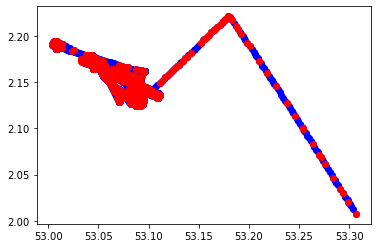

In [116]:
plt.scatter(df2[df2.mmsi==30128].lat,df2[df2.mmsi==30128].long,c='blue')
plt.scatter(df[df.mmsi==30128].lat,df[df.mmsi==30128].long,c='red')


In [ ]:
df2['lat'] = df2['lat'].interpolate(method="cubicspline")

In [14]:
def resample_ids(df, resampling_frq: int = 5):
    """

    Timestamps do not have fixed intervals.
    It ranges from less than 10 sec to more than hours aparts (amount of hours defined by ais.df_split_ais() )
    To account for this large varibility, and to add more generability in the NN, a resampling is performed.
    This resampling resampel the data using a mean method.



    First, we generate the underlying data grid by using mean().
    This generates the grid with NaNs as values. Afterwards, we fill the NaNs with interpolated values by calling the interpolate() method on the read value column
    """
    df.index = df.time

    try:
        df = (
                df.resample(f"{resampling_frq}min")
                .mean()
                .interpolate(method="cubicspline")
        )
        df = df.reset_index()
    except Exception as e:
        print(f"Error in resampling id: {df.ids.iloc[0]}: {e}")
 

    return df

In [9]:
df[df.ids=='31776_1']

,lat,mmsi,time,long,sog,cog,running_time,ids,running_distance,speed_calculated,bearing_calculated
49,53.019402,-31776,2019-03-29 12:54:41,2.432383,14.9,4.0,0.000000,31776_1,51.254629,inf,242.611481
50,53.040394,-31776,2019-03-29 12:59:49,2.434265,14.3,356.0,5.133333,31776_1,1.262218,14.753200,3.085186
51,53.043655,-31776,2019-03-29 13:00:44,2.433140,14.2,348.0,0.916667,31776_1,0.199992,13.090400,348.285950
52,53.045135,-31776,2019-03-29 13:01:04,2.432598,14.4,350.0,0.333333,31776_1,0.090994,16.378901,347.586121
53,53.048195,-31776,2019-03-29 13:01:56,2.431240,14.3,344.0,0.866667,31776_1,0.190115,13.161800,345.059265
...,...,...,...,...,...,...,...,...,...,...,...
44598,53.539291,31776,2019-03-29 19:56:29,3.829570,10.1,51.0,12.533333,31776_1,2.147412,10.280200,49.603046
44599,53.557079,31776,2019-03-29 20:06:28,3.866918,10.3,50.0,9.983333,31776_1,1.707534,10.262300,51.268898
44600,53.568085,31776,2019-03-29 20:12:37,3.888503,9.7,50.0,6.150000,31776_1,1.014452,9.897100,49.347313
44601,53.594109,31776,2019-03-29 20:26:38,3.941600,10.3,50.0,14.016667,31776_1,2.454280,10.505800,50.437088


In [8]:
df[df.speed_calculated>100].T

,29,35,49,80,81,260,271,344,374,408,...,44477,44555,44603,44743,44803,44933,44937,45011,45127,45192
lat,54.59647,53.030022,53.019402,53.616184,53.82098,54.022148,53.857761,53.86013,53.614033,55.537807,...,53.403481,53.003067,53.008137,53.022499,53.121342,53.054329,54.136002,55.925835,54.323582,54.04781
mmsi,-31920,-31812,-31776,-31536,-31384,-31264,-31103,-30528,-30344,-30072,...,31752,31776,32072,32128,32143,32264,32344,32648,32752,32760
time,2019-03-30 23:41:31,2019-03-30 21:59:16,2019-03-29 12:54:41,2019-03-29 06:12:22,2019-03-29 00:03:01,2019-03-30 22:24:20,2019-03-29 20:02:52,2019-03-30 05:13:44,2019-03-29 00:01:56,2019-03-29 08:09:21,...,2019-03-29 00:00:00,2019-03-29 16:18:39,2019-03-29 12:58:40,2019-03-30 03:05:36,2019-03-30 19:28:36,2019-03-30 18:00:22,2019-03-29 10:39:08,2019-03-30 14:35:56,2019-03-30 06:13:51,2019-03-29 19:43:25
long,2.403936,3.40615,2.432383,3.9781,3.34469,3.968518,3.99475,3.986088,3.620016,2.011968,...,3.422917,3.392397,2.490685,3.408,2.002225,3.982778,2.024146,3.983667,3.980988,3.98262
sog,9.0,12.8,14.9,18.9,10.3,12.8,12.6,12.1,10.9,14.0,...,4.8,9.3,10.8,5.9,9.6,10.9,12.2,19.4,13.0,14.8
cog,172.0,16.0,4.0,174.0,38.0,276.0,232.0,234.0,195.0,26.0,...,309.0,18.0,10.0,18.0,124.0,232.0,65.0,248.0,228.0,217.0
running_time,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,6.033333,0.0,0.0,0.0,0.0,0.0,0.0
ids,31920_1,31812_1,31776_1,31536_1,31384_1,31264_1,31103_1,30528_1,30344_1,30072_1,...,31752_1,31776_1,32072_1,32128_1,32143_1,32264_1,32344_1,32648_1,32752_1,32760_1
running_distance,102.881779,97.865857,51.254629,72.347239,25.64445,118.27572,23.413816,56.017535,36.789609,158.172684,...,138.394596,16.326406,64.545289,179.436486,76.40526,67.735178,94.56511,65.694092,88.493431,79.198378
speed_calculated,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,...,inf,inf,inf,1784.450806,inf,inf,inf,inf,inf,inf


Text(0, 0.5, 'speed calculated')

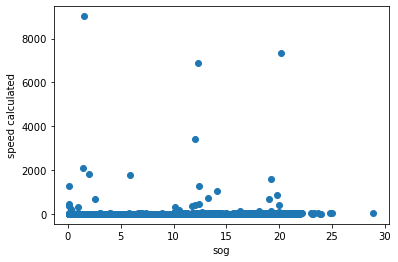

In [6]:
import matplotlib.pyplot as plt
plt.scatter(df.sog,df.speed_calculated)
plt.xlabel('sog')
plt.ylabel('speed calculated')

In [62]:
print(df.columns)

Index(['lat', 'mmsi', 'time', 'long', 'sog', 'cog', 'running_time', 'ids',
       'running_distance', 'total_distance', 'time_left', 'total_time',
       'distance_percentage', 'speed_calculated', 'bearing_calculated'],
      dtype='object')


In [24]:
del df['id']

In [25]:
df.head()

,mmsi,time,lat,long,sog,cog
375,17177,2019-03-29 00:00:00,55.398891,3.809998,0.0,0.000000
376,17177,2019-03-29 00:33:17,55.398891,3.809998,0.0,359.200012
377,17177,2019-03-29 00:45:15,55.398891,3.809998,0.0,359.200012
378,17177,2019-03-29 01:21:16,55.398891,3.809998,0.0,359.200012
379,17177,2019-03-29 01:57:16,55.398891,3.809998,0.0,359.200012


In [26]:
len(df.mmsi.unique())

363

In [27]:
with Ais_processing() as ais:
    ais.load_ais(df)
    


In [28]:
df.head()

,mmsi,time,lat,long,sog,cog
375,17177,2019-03-29 00:00:00,55.398891,3.809998,0.0,0.000000
376,17177,2019-03-29 00:33:17,55.398891,3.809998,0.0,359.200012
377,17177,2019-03-29 00:45:15,55.398891,3.809998,0.0,359.200012
378,17177,2019-03-29 01:21:16,55.398891,3.809998,0.0,359.200012
379,17177,2019-03-29 01:57:16,55.398891,3.809998,0.0,359.200012


In [29]:
ais.clean_ais()

In [30]:
df.head()

,mmsi,time,lat,long,sog,cog
375,17177,2019-03-29 00:00:00,55.398891,3.809998,0.0,0.000000
376,17177,2019-03-29 00:33:17,55.398891,3.809998,0.0,359.200012
377,17177,2019-03-29 00:45:15,55.398891,3.809998,0.0,359.200012
378,17177,2019-03-29 01:21:16,55.398891,3.809998,0.0,359.200012
379,17177,2019-03-29 01:57:16,55.398891,3.809998,0.0,359.200012


In [31]:
ais.get_trajectories(allowed_stop=100,min_messages=10)

In [32]:
len(ais.df.mmsi.unique())

282

In [33]:
ais.df.head()

,mmsi,time,lat,long,sog,cog,running_time,ids
0,-32672,2019-03-30 03:11:29,53.062241,3.513210,4.3,312.0,540.300000,32672_2
1,-32672,2019-03-30 03:21:30,53.057529,3.510620,2.1,190.0,10.016667,32672_2
2,-32672,2019-03-30 03:31:30,53.050934,3.507188,2.3,211.0,10.000000,32672_2
3,-32672,2019-03-30 03:41:30,53.044441,3.504300,2.1,210.0,10.000000,32672_2
4,-32672,2019-03-30 03:51:32,53.037930,3.501310,1.9,215.0,10.033333,32672_2


In [34]:
ais.add_derived_info()

In [35]:
ais.df.head()

,lat,mmsi,time,long,sog,cog,running_time,ids,running_distance,total_distance,time_left,total_time,distance_percentage,speed_calculated,bearing_calculated,delta_lat,delta_long
0,54.538658,-10149,2019-03-29 20:55:47,3.997828,12.2,215.0,0.000000,10149_1,0.000000,0.000000,509.05,0.000000,0.000000,12.2038,216.017380,0.000000,0.000000
1,54.510841,-10149,2019-03-29 21:05:56,3.963000,12.2,214.0,10.150000,10149_1,2.064483,2.064483,498.90,10.150000,0.019628,12.2038,216.017380,-0.027817,-0.034828
2,54.483028,-10149,2019-03-29 21:15:57,3.928868,12.2,214.0,10.016667,10149_1,2.050605,4.115088,488.88,20.166666,0.039124,12.2832,215.491028,-0.027813,-0.034132
3,54.455040,-10149,2019-03-29 21:26:08,3.894438,12.2,214.0,10.183333,10149_1,2.065694,6.180782,478.70,30.350000,0.058764,12.1710,215.574768,-0.027988,-0.034430
4,54.427479,-10149,2019-03-29 21:36:07,3.860598,12.2,215.0,9.983333,10149_1,2.033318,8.214101,468.72,40.333332,0.078096,12.2203,215.541290,-0.027561,-0.033840


In [36]:
ais.df.head()

,lat,mmsi,time,long,sog,cog,running_time,ids,running_distance,total_distance,time_left,total_time,distance_percentage,speed_calculated,bearing_calculated,delta_lat,delta_long
0,54.538658,-10149,2019-03-29 20:55:47,3.997828,12.2,215.0,0.000000,10149_1,0.000000,0.000000,509.05,0.000000,0.000000,12.2038,216.017380,0.000000,0.000000
1,54.510841,-10149,2019-03-29 21:05:56,3.963000,12.2,214.0,10.150000,10149_1,2.064483,2.064483,498.90,10.150000,0.019628,12.2038,216.017380,-0.027817,-0.034828
2,54.483028,-10149,2019-03-29 21:15:57,3.928868,12.2,214.0,10.016667,10149_1,2.050605,4.115088,488.88,20.166666,0.039124,12.2832,215.491028,-0.027813,-0.034132
3,54.455040,-10149,2019-03-29 21:26:08,3.894438,12.2,214.0,10.183333,10149_1,2.065694,6.180782,478.70,30.350000,0.058764,12.1710,215.574768,-0.027988,-0.034430
4,54.427479,-10149,2019-03-29 21:36:07,3.860598,12.2,215.0,9.983333,10149_1,2.033318,8.214101,468.72,40.333332,0.078096,12.2203,215.541290,-0.027561,-0.033840


In [ ]:
ais.save_df(filename='../data/test_data/ais_test', ext = 'pkl')